In [1]:
import gc
import pickle
import os
import torch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from modules.load_data import return_loaded_model
from modules.pickle_utils import load_pickle, get_pickle_path
from matplotlib.colors import ListedColormap
from numpy import interp
from seaborn import heatmap
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score, precision_recall_curve, auc, classification_report, confusion_matrix
from scipy.stats import kurtosis
from main import get_percentages

%matplotlib inline

In [2]:
target = 'VANCOMYCIN'
mimic_version = 4
n_time_steps = 14
seeds = [0, 1, 2, 3, 4]
debug = False
save_unimportant_figures = False

figure_format = 'png'
figure_dir = f'./output/figures/mimic_{mimic_version}'

if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())
print(f'{figure_dir=}')

0
1
NVIDIA GeForce RTX 2060
True
figure_dir='./output/figures/mimic_4'


## Data Exploration

In [3]:
## PICKLE LOADS
folder=f'./data/pickled_data_sets/mimic_{mimic_version}/{n_time_steps}_ts'
X_TRAIN = load_pickle(get_pickle_path('train_data', target, folder))
Y_TRAIN = load_pickle(get_pickle_path('train_targets', target, folder))
Y_VAL = load_pickle(get_pickle_path('validation_targets', target, folder))
X_TEST = load_pickle(get_pickle_path('test_data', target, folder))
Y_TEST = load_pickle(get_pickle_path('test_targets', target, folder))
x_boolmat_test = load_pickle(get_pickle_path('test_data_mask', target, folder))
y_boolmat_test = load_pickle(get_pickle_path('test_targets_mask', target, folder))
features = load_pickle(get_pickle_path('features', target, folder))
n_features = X_TRAIN.shape[2]
TIME_STEPS = X_TRAIN.shape[1] #number of time_steps

if target == 'MI':
    my_cmap = ListedColormap(sns.color_palette("Reds", 150))
    color_list = sns.color_palette("Reds", 14)
    color_list_reduced = sns.color_palette("Reds", 7) 
elif target == 'SEPSIS':
    my_cmap = sns.cubehelix_palette(14, start=2, rot=0, dark=0.25, light=.95, as_cmap=True)
    color_list = sns.cubehelix_palette(14, start=2, rot=0, dark=0.15, light=.8)
    color_list_reduced = sns.cubehelix_palette(7, start=2, rot=0, dark=0.15, light=.8)
elif target == 'VANCOMYCIN':
    my_cmap= sns.cubehelix_palette(14, as_cmap=True)
    color_list = sns.cubehelix_palette(14)
    color_list_reduced = sns.cubehelix_palette(7)
    
Y_TOTAL = np.concatenate([Y_TRAIN, Y_VAL, Y_TEST], axis=0)

In [4]:
print(n_features)
print(X_TRAIN.shape)

#TODO Marked for deletion if unused
X_TEST_2D = X_TEST.reshape(-1, n_features)  # Reshape to delete time dimension
data_rows = ~np.all(X_TEST_2D == 0, axis=1)
X_TEST_2D = X_TEST_2D[data_rows]
Y_TEST_2D = Y_TEST.reshape(-1, 1)
Y_TEST_2D = Y_TEST_2D[data_rows]
print(X_TEST_2D.shape, Y_TEST_2D.shape)

212
(111374, 13, 212)
(252434, 212) (252434, 1)


The total kurtosis of Total data is -0.16 with 35.92 % of events occuring between days 0 and 2
The total kurtosis of Training set is -0.43 with 33.01 % of events occuring between days 0 and 2
The total kurtosis of Validation set is 0.25 with 47.46 % of events occuring between days 0 and 2
The total kurtosis of Test set is 1.12 with 61.48 % of events occuring between days 0 and 2


<Figure size 432x288 with 0 Axes>

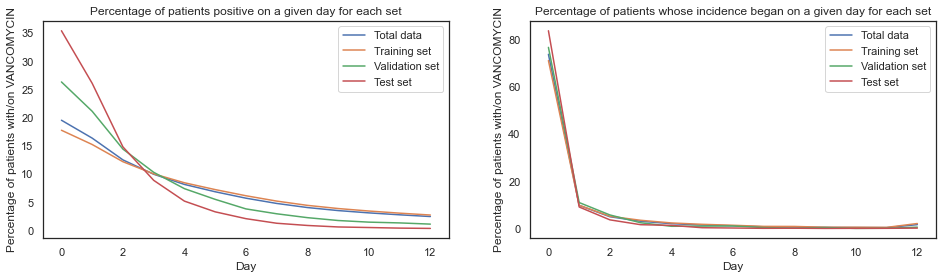

In [5]:
sets = [(Y_TOTAL, "Total data"), (Y_TRAIN, "Training set"), (Y_VAL, "Validation set"), (Y_TEST, "Test set")]
sns.set(style="white")
sns.despine(left=True, bottom=True)
    
## TOTAL

### When do people have incidents?

# number of people who are positive on a given day
plt.figure(figsize = (16,4))
plt.subplot(1, 2, 1)
plt.title('Percentage of patients positive on a given day for each set')
plt.ylabel('Percentage of patients with/on {0}'.format(target))
plt.xlabel('Day')
message = "The total kurtosis of {0} is {1:.2f} with {2:.2f} % of events occuring between days 0 and 2"
for y, label in sets:
    y_vector = np.nansum(y, axis=0).squeeze()
    print(message.format(label, kurtosis(y_vector), 100*int(np.sum(y_vector[0:2]))/np.sum(y_vector)))
    y_vector /= y_vector.sum()/100
    sns.lineplot(y=y_vector, x=np.arange(TIME_STEPS), label=label)
plt.legend()

# first incident - number of people who had their first incident on a given day
plt.subplot(1,2,2)
plt.title('Percentage of patients whose incidence began on a given day for each set')
plt.ylabel('Percentage of patients with/on {0}'.format(target))
plt.xlabel('Day')
for y, label in sets:
    POS_Y_TOTAL = y[np.nansum(y.squeeze(), axis=1) == 1]
    (days_total, value_counts_total) = np.unique(np.nanargmax(POS_Y_TOTAL, axis=1), return_counts=True)
    day_value_dict_total = dict(zip(np.arange(TIME_STEPS), np.zeros(TIME_STEPS)))
    for i in range(len(days_total)):
        day_value_dict_total[days_total[i]] = value_counts_total[i]
    y_vector_total_pos = np.array(list(day_value_dict_total.values()))
    y_vector_total_pos = y_vector_total_pos * 100 /y_vector_total_pos.sum()
    sns.lineplot(y=y_vector_total_pos, x=np.arange(TIME_STEPS), label=label)
plt.legend()

if save_unimportant_figures:
    plt.savefig(f'{figure_dir}/{target}_Set_Distributions.{figure_format}', 
                format=figure_format, dpi=300, bbox_inches='tight')
else:
    plt.show()

In [6]:
def get_model_name(model_type, mimic_version, target, n_time_steps, seed):
    return f'{model_type}_{mimic_version}_{target}_{n_time_steps}_{seed}'

def load_model(model_name):
    return return_loaded_model(model_name).cpu()

def get_model_dict(model_type, mimic_version, target, n_time_steps, seed):
    model_dict = dict()

    for model_type in model_types:
        model_dict[model_type] = []
        for seed in seeds:
            model_name = get_model_name(model_type, mimic_version, target, n_time_steps, seed)
            model = load_model(model_name)
            model.eval()
            model_dict[model_type].append(model)
    
    return model_dict

def print_param_count(model_dict):
    for model_type in model_dict.keys():
        model = model_dict[model_type][0]

        num_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f'{model_type} number of Parameters: {num_param}')

        for name, p in model.named_parameters():
            if p.requires_grad:
                print(f'\t{name}: {p.numel()}')

## Is the time component important/ is a FNN sufficient

dict_keys(['partial_attention_LSTM', 'comparison_LSTM', 'comparison_FNN'])
partial_attention_LSTM number of Parameters: 526481
	attention_layer.weight: 44944
	lstm.weight_ih_l0: 217088
	lstm.weight_hh_l0: 262144
	lstm.bias_ih_l0: 1024
	lstm.bias_hh_l0: 1024
	dense.weight: 256
	dense.bias: 1
comparison_LSTM number of Parameters: 481537
	lstm.weight_ih_l0: 217088
	lstm.weight_hh_l0: 262144
	lstm.bias_ih_l0: 1024
	lstm.bias_hh_l0: 1024
	dense.weight: 256
	dense.bias: 1
comparison_FNN number of Parameters: 481501
	linear.weight: 477000
	linear.bias: 2250
	dense.weight: 2250
	dense.bias: 1


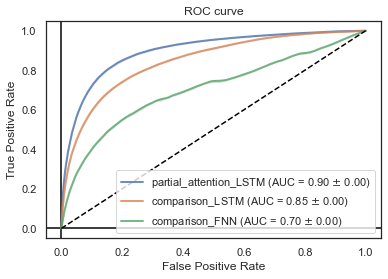

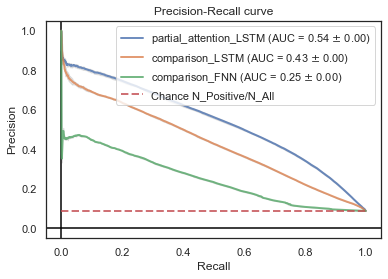

In [7]:
def get_prediction_dict(input_data, model_dict):
    prediction_dict = dict()
    with torch.no_grad():
        X_tensor = torch.tensor(input_data, dtype=torch.float).clone().detach()
        for model_type in model_dict.keys():
            prediction_dict[model_type] = []
            for model in model_dict[model_type]:
                prediction = model(X_tensor)
                prediction_dict[model_type].append(prediction.detach().numpy())
    return prediction_dict

def plot_curves(predictions, plot_roc, Y_TEST, y_boolmat_test, save_fig=True):
    y = Y_TEST[~y_boolmat_test]
    mean_x = np.linspace(0, 1, 1000)
    
    plt.figure()
    plt.axhline(0, color='black')
    plt.axvline(0, color='black')
    for model_type in predictions.keys():
        y_value_list = []
        auc_list = []
        for prediction in predictions[model_type]:
            if plot_roc:
                x_values, y_values, thresholds = roc_curve(y, prediction[~y_boolmat_test])
            else:
                y_values, x_values, thresholds = precision_recall_curve(y,  prediction[~y_boolmat_test])
                y_values = y_values[::-1]
            # plt.plot(x_values, y_values)
            y_value_list.append(interp(mean_x, sorted(x_values), y_values))
            area_uc = auc(x_values, y_values)
            auc_list.append(area_uc)

        mean_y = np.mean(y_value_list, axis=0)
        mean_auc = auc(mean_x, mean_y)
        std_auc = np.std(auc_list)
        plt.plot(mean_x, mean_y, lw=2, alpha=.8, label=str(model_type) + r' (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc))

        std_y = np.std(y_value_list, axis=0)
        upper_y = np.minimum(mean_y + std_y, 1)
        lower_y = np.maximum(mean_y - std_y, 0)
        plt.fill_between(mean_x, lower_y, upper_y, color='grey', alpha=.2)

    if plot_roc:
        xlabel = 'False Positive Rate'
        ylabel = 'True Positive Rate'
        title = 'ROC curve'
        plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    else:
        xlabel = 'Recall'
        ylabel = 'Precision'
        title = 'Precision-Recall curve'
        chance = len(y[y==1])/len(y)
        plt.plot([0, 1], [chance, chance], linestyle='--', lw=2, color='r', label='Chance N_Positive/N_All', alpha=.8)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc="best")
    if save_fig:
        plt.savefig(f'{figure_dir}/{target}_{title}.{figure_format}',
                    format=figure_format, dpi=300, facecolor='white', transparent=True, bbox_inches='tight')
    else:
        plt.show()
    
def compare_NN_RNN(model_types, mimic_version, target, n_time_steps, seeds, X_TEST, Y_TEST, y_boolmat_test):
    model_dict_time = get_model_dict(model_types, mimic_version, target, n_time_steps, seeds)
    print(model_dict_time.keys())
    print_param_count(model_dict_time)
    
    predictions = get_prediction_dict(X_TEST, model_dict_time)
    
    plot_curves(predictions, True, Y_TEST, y_boolmat_test)
    plot_curves(predictions, False, Y_TEST, y_boolmat_test)

    

model_types = ['partial_attention_LSTM', 'comparison_LSTM', 'comparison_FNN']
compare_NN_RNN(model_types, mimic_version, target, n_time_steps, seeds, X_TEST, Y_TEST, y_boolmat_test)

## Finding out which Window Size yields the best results

dict_keys([14, 28])
14 number of Parameters: 526481
	attention_layer.weight: 44944
	lstm.weight_ih_l0: 217088
	lstm.weight_hh_l0: 262144
	lstm.bias_ih_l0: 1024
	lstm.bias_hh_l0: 1024
	dense.weight: 256
	dense.bias: 1
28 number of Parameters: 526481
	attention_layer.weight: 44944
	lstm.weight_ih_l0: 217088
	lstm.weight_hh_l0: 262144
	lstm.bias_ih_l0: 1024
	lstm.bias_hh_l0: 1024
	dense.weight: 256
	dense.bias: 1


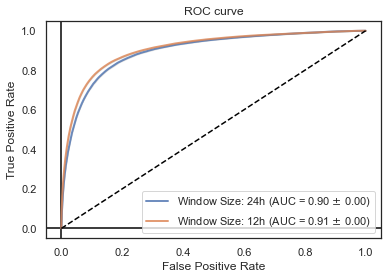

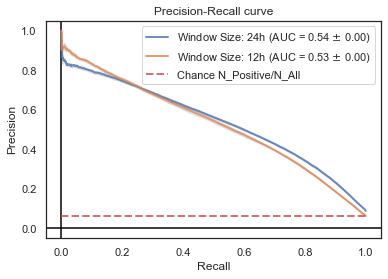

In [8]:
def get_model_dict_nts(n_time_steps, model_type='partial_attention_LSTM'):
    model_dict_nts = dict()

    for nts in n_time_steps:
        model_dict_nts[nts] = []
        for seed in seeds:
            model_name = get_model_name(model_type, mimic_version, target, nts, seed)
            model = load_model(model_name)
            model.eval()
            model_dict_nts[nts].append(model)
            
    return model_dict_nts

def get_prediction_dict_multiple_data(input_data, model_dict):
    predictions_nts = dict()
    tensor_inputs = []
    for in_data in input_data:
        tensor_inputs.append(torch.tensor(in_data, dtype=torch.float).clone().detach())
    with torch.no_grad():
        for key, input_data_tensor in zip(model_dict.keys(), tensor_inputs):
            predictions_nts[key] = []
            for model in model_dict[key]:
                prediction = model(input_data_tensor)
                predictions_nts[key].append(prediction.detach().numpy())
    return predictions_nts

def plot_curves_nts(predictions, plot_roc, y_list, boolmats, save_fig=True):
    mean_x = np.linspace(0, 1, 1000)
    
    plt.figure()
    plt.axhline(0, color='black')
    plt.axvline(0, color='black')
    for model_type, y, boolmat in zip(predictions.keys(), y_list, boolmats):
        y_value_list = []
        auc_list = []
        for prediction in predictions[model_type]:
            if plot_roc:
                x_values, y_values, thresholds = roc_curve(y, prediction[~boolmat])
            else:
                y_values, x_values, thresholds = precision_recall_curve(y,  prediction[~boolmat])
                y_values = y_values[::-1]
            # plt.plot(x_values, y_values)
            y_value_list.append(interp(mean_x, sorted(x_values), y_values))
            area_uc = auc(x_values, y_values)
            auc_list.append(area_uc)

        mean_y = np.mean(y_value_list, axis=0)
        mean_auc = auc(mean_x, mean_y)
        std_auc = np.std(auc_list)
        plt.plot(mean_x, mean_y, lw=2, alpha=.8, label='Window Size: ' + str(24 * 14 // model_type) + r'h (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc))

        std_y = np.std(y_value_list, axis=0)
        upper_y = np.minimum(mean_y + std_y, 1)
        lower_y = np.maximum(mean_y - std_y, 0)
        plt.fill_between(mean_x, lower_y, upper_y, color='grey', alpha=.2)

    if plot_roc:
        xlabel = 'False Positive Rate'
        ylabel = 'True Positive Rate'
        title = 'ROC curve'
        plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    else:
        xlabel = 'Recall'
        ylabel = 'Precision'
        title = 'Precision-Recall curve'
        chance = len(y[y==1])/len(y)
        plt.plot([0, 1], [chance, chance], linestyle='--', lw=2, color='r', label='Chance N_Positive/N_All', alpha=.8)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc="best")
    if save_fig:
        plt.savefig(f'{figure_dir}/{target}_{title}.{figure_format}',
                    format=figure_format, dpi=300, facecolor='white', transparent=True, bbox_inches='tight')
    else:
        plt.show()

def compare_window_size(n_time_steps, mimic_version, target, X_TEST, Y_TEST, y_boolmat_test):
    second_time_step = 28
    model_dict_nts = get_model_dict_nts([n_time_steps, second_time_step])
    print(model_dict_nts.keys())
    print_param_count(model_dict_nts)
    
    folder_28 = f'./data/pickled_data_sets/mimic_{mimic_version}/{second_time_step}_ts'
    X_TEST_28 = load_pickle(get_pickle_path('test_data', target, folder_28))
    predictions_nts = get_prediction_dict_multiple_data([X_TEST, X_TEST_28], model_dict_nts)
    
    #Plotting
    Y_TEST_28 = load_pickle(get_pickle_path('test_targets', target, folder_28))
    y_boolmat_test_28 = load_pickle(get_pickle_path('test_targets_mask', target, folder_28))
    y_list = [Y_TEST[~y_boolmat_test], Y_TEST_28[~y_boolmat_test_28]]
    boolmats = [y_boolmat_test, y_boolmat_test_28]
    
    plot_curves_nts(predictions_nts, True, y_list, boolmats)
    plot_curves_nts(predictions_nts, False, y_list, boolmats)

compare_window_size(n_time_steps, mimic_version, target, X_TEST, Y_TEST, y_boolmat_test)

In [ ]:
"""TN, FP, FN, TP = confusion_matrix(Y_TEST[~y_boolmat_test], np.around(Y_PRED_mask_0[~y_boolmat_test])).ravel()
PPV = TP/(TP+FP)
print("PPV for full model is {0}".format(PPV))
CR = classification_report(Y_TEST[~y_boolmat_test], np.around(Y_PRED_mask_0[~y_boolmat_test]))

print("Sensitivity for full model is {0}".format(CR.split('\n')[3].split()[2]))
# classification_report(Y_TEST[~y_boolmat_test], np.around(Y_PRED_mask_0[~y_boolmat_test]))

print(classification_report(Y_TEST[~y_boolmat_test], np.around(Y_PRED_mask_0[~y_boolmat_test])))"""

In [ ]:
# GET ACTIVATIONS MATRIX ; OUTPUT IS (BATCH_SIZE, TIME_STEPS, FEATURES)
model_dict[m](X_TEST)
activations = model_dict[m].attention
activations[x_boolmat_test] = np.nan

# AVERAGE THE ATTENTION MATRIX OVER FEATURES ; OUTPUT IS BATCH_SIZE, TIME_STEPS
attention_matrix = np.nanmean(activations, axis=2).squeeze()

# AVERAGE ATTENTION VECTOR ACROSS SAMPLES ; OUTPUT IS 1D TIME_STEPS
attention_vector_final = np.nanmean(attention_matrix, axis=0)

# This allows us to rank color intensity by activation. We sort the intensities, then argsort the indices ##
color_order = np.argsort(attention_vector_final, axis=0)
color_order_order = np.argsort(color_order)

In [ ]:
attention_vector_final

In [ ]:
''' Due to the way features are selectd from the EMR and the fact potassium can be a 
delivered medication or a lab value, special care was taken to ensure proper representation on heatmaps '''

if 'digoxin(?!.*fab)' in features:
    indexy = features.index('digoxin(?!.*fab)')
    features[indexy] = 'digoxin'
    
if 'potassium_y' in features:
    indexy = features.index('potassium_y')
    features[indexy] = 'potassium_med'
    
if 'potassium_x' in features:
    indexy = features.index('potassium_x')
    features[indexy] = 'potassium'
    
if 'cipfloxacin' in features:
    indexy = features.index('cipfloxacin')
    features[indexy] = 'ciprofloxacin'

features = [feature.lower() for feature in features]

In [ ]:
## FEATURES BY CATEGORY ##

cbc_diff_features = ['RBCs', 'WBCs', 'platelets', 'hemoglobin', 'hemocrit', 
                              'atypical lymphocytes', 'bands', 'basophils', 'eosinophils', 'neutrophils',
                              'lymphocytes', 'monocytes', 'polymorphonuclear leukocytes']
                      
vital_features = ['temperature (F)', 'heart rate', 'respiratory rate', 'systolic', 'diastolic',
                  'pulse oximetry']

lab_features = ['troponin', 'HDL', 'LDL', 'BUN', 'INR', 'PTT', 'PT', 'triglycerides', 'creatinine',
                  'glucose', 'sodium', 'potassium', 'chloride', 'bicarbonate',
                  'blood culture', 'urine culture', 'surface culture', 'sputum' + 
                  ' culture', 'wound culture', 'Inspired O2 Fraction', 'central venous pressure', 
                  'PEEP Set', 'tidal volume', 'anion gap']
                  
demographic_features = ['age', 'm', 'black', 'daily weight', 'tobacco', 'diabetes', 'history of CV events']

med_features = ['epoetin', 'warfarin', 'heparin', 'enoxaparin', 'fondaparinux',
                                      'asprin', 'ketorolac', 'acetominophen', 
                                      'insulin', 'glucagon', 
                                      'potassium_med', 'calcium gluconate', 
                                      'fentanyl', 'magensium sulfate', 
                                      'D5W', 'dextrose', 
                                      'ranitidine', 'ondansetron', 'pantoprazole', 'metoclopramide', 
                                      'lisinopril', 'captopril', 'statin',  
                                      'hydralazine', 'diltiazem', 
                                      'carvedilol', 'metoprolol', 'labetalol', 'atenolol',
                                      'amiodarone', 'digoxin',
                                      'clopidogrel', 'nitroprusside', 'nitroglycerin',
                                      'vasopressin', 'hydrochlorothiazide', 'furosemide', 
                                      'atropine', 'neostigmine',
                                      'levothyroxine',
                                      'oxycodone', 'hydromorphone', 'fentanyl citrate', 
                                      'tacrolimus', 'prednisone', 
                                      'phenylephrine', 'norepinephrine',
                                      'haloperidol', 'phenytoin', 'trazodone', 'levetiracetam',
                                      'diazepam', 'clonazepam',
                                      'propofol', 'zolpidem', 'midazolam', 
                                      'albuterol', 'ipratropium', 
                                      'diphenhydramine',  
                                      '0.9% Sodium Chloride',
                                      'phytonadione', 
                                      'metronidazole', 
                                      'cefazolin', 'cefepime', 'vancomycin', 'levofloxacin',
                                      'ciprofloxacin', 'fluconazole', 
                                      'meropenem', 'ceftriaxone', 'piperacillin',
                                      'ampicillin-sulbactam', 'nafcillin', 'oxacillin',
                                      'amoxicillin', 'penicillin', 'SMX-TMP']

cbc_diff_features = [[i.lower(), i.lower()+'_min', i.lower()+'_max', i.lower()+'_std'] for i in cbc_diff_features]
vital_features = [[i.lower(), i.lower()+'_min', i.lower()+'_max', i.lower()+'_std'] for i in vital_features]
lab_features = [[i.lower(), i.lower()+'_min', i.lower()+'_max', i.lower()+'_std'] for i in lab_features]
demographic_features = [i.lower() for i in demographic_features]
med_features = [i.lower() for i in med_features]

cbc_diff_feature_array = np.array(cbc_diff_features).flatten()
vital_features_array = np.array(vital_features).flatten()
lab_features_array = np.array(lab_features).flatten()
demographic_feature_array = np.array(demographic_features).flatten()
med_features_array = np.array(med_features).flatten()

features_built = np.hstack([cbc_diff_feature_array,vital_features_array,
                            lab_features_array,demographic_feature_array,med_features_array])

features_built_reduced = [i for i in features_built if i in features]

In [ ]:
## Identifies the index in the features list in the desired order ##
arranged_indices = [features.index(i) for i in features_built_reduced]
## This is a sanity check to ensure that features_built_reduced has the same number of elements as our target ##
print(len(features))
print(len(features_built_reduced))
assert len(features) == len(features_built_reduced)
print(list(set(features) - set(features_built_reduced)))

In [ ]:
##############
## FIGURE 1 ##
##############
#Set padding as well as defined number of days (mask) to zero
#Y_PRED_mask_X has set days from X onward to 0
mask_value = 0
y_pred_mask_dict = dict()
with torch.no_grad():
    X_TEST_MASK = X_TEST.clone().detach()
    X_TEST_MASK[x_boolmat_test] = 0

    prediction, hidden = model_dict[m](X_TEST_MASK)
    y_pred_mask_dict[0] = prediction.detach().numpy()
    for mask in reversed(range(1, TIME_STEPS)):
        X_TEST_MASK[:,mask:,:] = mask_value
        prediction, hidden = model_dict[m](X_TEST_MASK)
        if debug:
            print(f"m={mask}: {prediction[4,:,0]}")
        y_pred_mask_dict[mask] = prediction.detach().numpy()

In [ ]:
#Proving that the model does remember its prior states but 
#only returns a specific value if the inputs are pad values only
#for tensorflow 2.3.1
if debug:
    X_TEST_MASK = X_TEST.clone().detach().numpy()
    mask = 2
    X_TEST_MASK[x_boolmat_test] = 0
    X_TEST_MASK[:,mask:,:] = 0
    # Selecting first 3 samples
    X_TEST_MASK = X_TEST_MASK[0:3,:,:]
    # Setting the 2. day features of the first 2 samples to that of the third
    X_TEST_MASK[0:2,1,:] = X_TEST_MASK[2,1,:]
    #Printing first 5 features
    print(f"Data X:\n{X_TEST_MASK[:,:4,0:5]}\nPrediction Y:")
    print(model_dict[m](torch.tensor(X_TEST_MASK))[0][:,:4,:])

In [ ]:
##############
## FIGURE 1 ##
##############

#~y_boolmat_test yields all non padded entries
#Y_PRED_mask_X[~y_boolmat_test] yields an array of
#non padded entries where from day X onward the entries are set to 0
#Because the network was trained with padding values I assume that it automatically returns the same result 
#ignoring the prior states
fpr_tpr_dict = dict()
roc_aucs = []
for mask in reversed(y_pred_mask_dict.keys()):
    (fpr, tpr, thresholds) = roc_curve(Y_TEST[~y_boolmat_test], y_pred_mask_dict[mask][~y_boolmat_test])
    fpr_tpr_dict[mask] = (fpr, tpr)
    roc_auc = roc_auc_score(Y_TEST[~y_boolmat_test], y_pred_mask_dict[mask][~y_boolmat_test])
    if mask != 0:
        print(f'Mask from day {mask + 1:02d} onward with ROC AUC: {roc_auc}')
    else:
        print(f'No masking \t\twith ROC AUC: {roc_auc}')
    roc_aucs.append(roc_auc)

fpr_tprs = fpr_tpr_dict.values()

In [ ]:
##############
## FIGURE 1 ##
##############

fig, ax = plt.subplots()
ax.set_facecolor('white')

counter = 1

for color, fpr_tpr_tuple, auc in zip(color_list, fpr_tprs, roc_aucs):
    label = f'Mask Post Day {counter}'
    if counter == 14:
        label='No Mask'
    label += f" | AUC {auc:.4f}"
    plt.plot(fpr_tpr_tuple[0], fpr_tpr_tuple[1], label=label, color=color)
    counter += 1
        
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
legend = plt.legend(loc="lower right", prop={'size': 10}, bbox_to_anchor=(1.41, 0))
plt.savefig(f'{figure_dir}/{target}_roc_curves_Fig_1.{figure_format}', format=figure_format,
             dpi=300, facecolor='white', transparent=True, bbox_extra_artists=(legend,), bbox_inches='tight')

In [ ]:
##############################
## FIGURE 2 LAG EXPERIMENTS ##
##############################             
y_test_lag_dict = dict()    
y_pred_lag_dict = dict()
fpr_tpr_dict = dict()
roc_aucs = []
max_start_day = 7

for start in range(1, max_start_day + 1):
    ### 1 DAY LAGGED EXPERIMENTS ###      
    ### all the first days of every person, all the second days, third days, in a 1D vector
    y_test_lag = [Y_TEST[:,i][~y_boolmat_test[:,i,::]] for i in range(start, TIME_STEPS)]
    y_test_lag = np.concatenate(y_test_lag, axis=0)
    y_test_lag_dict[start] = y_test_lag

    # Selects the second day of "masking from second day onward" up to
    # 14th day from masking 14th day onward => only has the value for paddings in predictions   
    y_pred_lag = [y_pred_mask_dict[i - start + 1][:,i,::][~y_boolmat_test[:,i,::]] for i in range(start, TIME_STEPS)]
    y_pred_lag = np.concatenate(y_pred_lag, axis=0)
    y_pred_lag_dict[start] = y_pred_lag

    ## LAG ROC ##
    auc = roc_auc_score(y_test_lag, y_pred_lag)
    print(f'Day {start} Lag with ROC AUC: {auc}')
    roc_aucs.append(auc)
    
    (fpr, tpr, thresholds) = roc_curve(y_test_lag, y_pred_lag)
    fpr_tpr_dict[start] = (fpr, tpr)

fpr_tprs = fpr_tpr_dict.values()

Y_TEST_LAG_1 = y_test_lag_dict[1]                             
Y_PRED_LAG_1 = y_pred_lag_dict[1]


confusion_matrix(Y_TEST_LAG_1, np.around(Y_PRED_LAG_1))

## 100% Training Data with 1 day lag ##
TN, FP, FN, TP = confusion_matrix(Y_TEST_LAG_1, np.around(Y_PRED_LAG_1)).ravel()
PPV = TP/(TP+FP)
print("PPV for full model w/ 1 day lag is {0}".format(PPV))
CR = classification_report(Y_TEST_LAG_1, np.around(Y_PRED_LAG_1))

print("Sensitivity for full model w/ 1 day lag is {0}".format(CR.split('\n')[3].split()[2]))

print(classification_report(Y_TEST_LAG_1, np.around(Y_PRED_LAG_1)))

In [ ]:
fig, ax = plt.subplots()
ax.set_facecolor('white')

days = range(1, max_start_day + 1)
for color, fpr_tpr_tuple, i, auc in zip(np.array(color_list_reduced)[-1:0:-1], fpr_tprs, days, roc_aucs):
    label = f'{i} Day Lag | AUC: {auc:.4f}'
    plt.plot(fpr_tpr_tuple[0], fpr_tpr_tuple[1], label=label, color=color)

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
legend = plt.legend(loc="lower right", prop={'size': 10}, bbox_to_anchor=(1.29, 0.05))
plt.savefig(f'{figure_dir}/{target}_lagged_roc_curves_Fig_2.{figure_format}', format=figure_format,
             dpi=300, facecolor='white', transparent=True, bbox_extra_artists=(legend,), bbox_inches='tight')

In [ ]:
##############
## FIGURE 3 ##
##############

## GET HEATMAPS FOR ALL INCIDENTS AVERAGE ##

plt.figure(figsize = (8,20))

sns.set(font_scale = 0.5)

heatmap(np.nanmean(activations,axis=0).T[arranged_indices], 
        square=False, 
        yticklabels=np.array(features)[arranged_indices],
        cmap=my_cmap)
plt.gcf().axes[-1].tick_params(labelsize=10)
plt.xticks(np.arange(TIME_STEPS)+0.5, np.arange(TIME_STEPS), fontsize=15) #, rotation=45,)
plt.xlabel('Day', fontsize=15)
plt.ylabel('Features', fontsize=20)
plt.savefig(f'{figure_dir}/heatmap_{target}_med_ranked_average_activation_Figure_3.{figure_format}', 
            format=figure_format, dpi=300, bbox_inches='tight')

## MAKE THE BARPLOT THAT GOES ON TOP OF THE HEATMAP ##
## THE ATTENTION ON EVERY TIME STEP AVERAGED OVER FEATURES ##

plt.figure(figsize = (8,4)) 
sns.set(style="white")
y_vector = np.nanmean(np.nanmean(activations,axis=0).squeeze(), axis=1)
print('There is a {0} % change between day 0 and 1'.format((y_vector[1] - y_vector[0])/float(y_vector[0])))
color_rank = np.argsort(np.argsort(y_vector))
plot = sns.barplot(x=list(range(14)), y=np.nanmean(np.nanmean(activations,axis=0).squeeze(), axis=1), 
                    palette=np.array(color_list)[color_rank])
plt.xlabel('Day', fontsize=15)
plt.ylabel('Feature Activation', fontsize=20)
sns.despine()# left=True, bottom=True)
#plot.set(xticklabels=[]) 
#plot.set(yticklabels=[])
#sns.despine(left=True, bottom=True)

plt.savefig(f'{figure_dir}/{target}_heatmap_med_ranked_average_barplot_Figure_3.{figure_format}', 
            format=figure_format, dpi=300, bbox_inches='tight')

## IDENTIFY MOST IMPORTANT FEATURE AT EVERY TIME STEP ##

plt.figure(figsize = (8,4)) 
sns.set(style="white")
y_vector = np.nanmax(np.nanmean(activations, axis=0).T[arranged_indices], axis=0)
color_rank = np.argsort(np.argsort(y_vector))
plot = sns.barplot(x=list(range(14)), y=np.nanmax(np.nanmean(activations, axis=0).T[arranged_indices], axis=0), 
                    palette=np.array(color_list)[color_rank])
plt.xlabel('Day', fontsize=15)
plt.ylabel('Feature Activation', fontsize=20)
sns.despine()# left=True, bottom=True)

plt.savefig(f'{figure_dir}/{target}_highest_feature_activation_by_timestep_barplot_Figure_3.{figure_format}', 
            format=figure_format, dpi=300, bbox_inches='tight')

## list of features by day that these activations correspond to ##

np.nanargmax(np.nanmean(activations, axis=0).T[arranged_indices], axis=0)
print(np.array(features)[arranged_indices][np.nanargmax(np.nanmean(activations, axis=0).T[arranged_indices], 
                                                     axis=0)])
#####

In [ ]:
def find_intrahospital_incidents():
    IHI_keys =  np.where(np.nansum(Y_TEST.squeeze(), axis=1) > 1)[0]
    for i in IHI_keys:
        predictions = Y_PRED_mask_0[i][~y_boolmat_test[i].squeeze()].squeeze()
        ground_truth = Y_TEST[i].squeeze()[~y_boolmat_test[i].squeeze()].squeeze()
        acc = accuracy_score(np.around(predictions), ground_truth)
        criteria = (acc > .9 and 
                    (np.add(ground_truth, np.around(predictions)) == 2).any()  and
                    (ground_truth[0] == 0) and
                    1 in ground_truth and
                    ground_truth.shape[0] == 14)
        if criteria:
            print("Person {0} with IHI".format(i))
            print('Ground Truth')
            print(ground_truth)
            print('Predicted Sequence')
            print(np.around(predictions))
            print('\n')
            return i
        
patient_num = find_intrahospital_incidents()

if False:
    if target == 'MI':
        patient_num = 3947
    elif target == 'SEPSIS':
        patient_num = 927
    elif target == 'VANCOMYCIN':
        patient_num = 210#1372 

In [ ]:
def patient_heatmap(X_TEST, patient_num, savefig=False, target=None):   
        if target == None:
            raise Exception('Specify Target')
            
        print('\n')
        print('Visualize Inputs')
        print('Ground Truth')
        ground_truth = Y_TEST[patient_num].squeeze()[~y_boolmat_test[patient_num].squeeze()]
        print(np.sum(ground_truth))
        print('Predicted Sequence')
        predictions = Y_PRED_mask_0[patient_num].squeeze()[~y_boolmat_test[patient_num].squeeze()]
        print(np.sum(np.around(predictions)))
        
        if target == 'MI':
            color_list_barplot = sns.color_palette("Reds", ground_truth.shape[0])
        elif target == 'SEPSIS':
            color_list_barplot = sns.cubehelix_palette(ground_truth.shape[0], start=2, rot=0, dark=0.25, light=.95)
        elif target == 'VANCOMYCIN':
            color_list_barplot = sns.cubehelix_palette(ground_truth.shape[0])
        
        print('Individual Heatmap')
        plt.figure(figsize = (8,20))
        sns.set(font_scale = 0.5)
        
        activations_map = activations[patient_num]/np.nanmax(activations[patient_num,::,::], axis=1)[:,None]
        heatmap(activations[patient_num].T[arranged_indices],
                square=False,
                yticklabels=np.array(features)[arranged_indices], cmap=my_cmap)
        plt.gcf().axes[-1].tick_params(labelsize=10) 
        plt.xticks(np.arange(TIME_STEPS)+0.5, np.arange(TIME_STEPS), fontsize=15)
        plt.yticks(fontsize=8)
        plt.xlabel('Day', fontsize=20)
        plt.ylabel('Features', fontsize=20)
        plt.xticks(np.arange(TIME_STEPS)+0.5, np.arange(TIME_STEPS), fontsize=15) #, rotation=45,)
        
        if savefig:
            plt.savefig(f'{figure_dir}/heatmap_{target}_patient_{patient_num}.{figure_format}', 
                        format=figure_format, dpi=300, bbox_inches='tight')
        
        rel_vector = np.nanmean(activations[patient_num,::,::].T.squeeze(), axis=0)
        rel_vector = rel_vector[~y_boolmat_test[patient_num].squeeze()]
        color_order = np.argsort(rel_vector, axis=0)
        color_order_order = np.argsort(color_order)

        plt.figure(figsize = (8,4)) 
        sns.set(style="white")
        plot = sns.barplot(x=np.arange(14)[~y_boolmat_test[patient_num].squeeze()], y=rel_vector, 
                           palette=np.array(color_list_barplot)[color_order_order])
        plot.set(xticklabels=[]) 
        plot.set(yticklabels=[])
        sns.despine(left=True, bottom=True)
        
        print('Patient Features Heatmap')
        if savefig:
            plt.savefig(f'{figure_dir}/barplot_for_heatmap_{target}_patient_{patient_num}.{figure_format}', 
                        format=figure_format, dpi=300, bbox_inches='tight')
        
        plt.figure(figsize= (8,20))
        sns.set(font_scale = 0.5)
        activations_map = X_TEST[patient_num,::,::]/np.nanmax(X_TEST[patient_num,::,::], axis=0) #[:,None]
        heatmap(X_TEST[patient_num,::,::].T[arranged_indices], square=False, 
                yticklabels=np.array(features)[arranged_indices], 
                cmap=my_cmap) #, cbar_kws={'ticks':[]})
        plt.gcf().axes[-1].tick_params(labelsize=10)
        plt.xticks(np.arange(TIME_STEPS)+0.5, np.arange(TIME_STEPS), fontsize=15) #, rotation=45,)
        plt.yticks(fontsize=8)
        plt.xlabel('Day', fontsize=20)
        plt.ylabel('Features', fontsize=20)
        plt.xticks(np.arange(TIME_STEPS)+0.5, np.arange(TIME_STEPS), fontsize=15) #, rotation=45,)
        if savefig:
            plt.savefig(f'{figure_dir}/features_heatmap_{target}_patient_{patient_num}.{figure_format}', 
                        format=figure_format, dpi=300, bbox_inches='tight')
            
        rel_vector = np.nanmean(X_TEST[patient_num,::,::].T.squeeze(), axis=0)[~y_boolmat_test[patient_num].squeeze()]
        color_order = np.argsort(rel_vector, axis=0)
        color_order_order = np.argsort(color_order)

        plt.figure(figsize = (8,4)) 
        sns.set(style="white")
        plot = sns.barplot(x=np.arange(14)[~y_boolmat_test[patient_num].squeeze()], y=rel_vector, 
                           palette=np.array(color_list_barplot)[color_order_order])
        plot.set(xticklabels=[]) 
        plot.set(yticklabels=[])
        sns.despine(left=True, bottom=True)
        if savefig:
            plt.savefig(f'{figure_dir}/barplot_features_heatmap_{target}_patient_{patient_num}.{figure_format}', 
                        format=figure_format, dpi=300, bbox_inches='tight')

In [ ]:
## Example use of patient_heatmap
patient_heatmap(X_TEST.detach().numpy(), patient_num, savefig=save_unimportant_figures, target=target)

In [ ]:
## Get the top activations for that day, the day before, the day before ##

def features_driving_incident(patient_num, savefig=False):
    
    plt.figure(figsize = (8,4)) 
    sns.set(style="white")
    
    if np.where(Y_TEST[patient_num] == 1)[0][0] == 1:
        day_zero = 1
        day_neg_one = 0
        days = np.array([day_neg_one, day_zero])
        days_string = ['Day -1', 'Day 0']
    else:
        assert np.where(Y_TEST[patient_num] == 1)[0][0] >= 2
        day_zero = np.where(Y_TEST[patient_num] == 1)[0][0]
        day_neg_one = day_zero - 1
        day_neg_two = day_zero - 2
        days = np.array([day_neg_two, day_neg_one, day_zero])
        days_string = ['Day -2', 'Day -1', 'Day 0']
       
    y_vector = np.nanmax(activations[patient_num], axis=1)#[days]
    print(y_vector)
    print(np.nansum(y_vector))
    color_rank = np.argsort(np.argsort(y_vector))
    plot = sns.barplot(x=days_string, y=y_vector[days], 
                       palette=np.array(color_list)[color_rank][days])
    plt.ylabel('Feature Activation', fontsize=20)
        #plot.set(xticklabels=[]) 
        #plot.set(yticklabels=[])
    sns.despine() # left=True, bottom=True)

    if savefig:
        plt.savefig(f'{figure_dir}/max_activation_pre_incident_barplot_Figure_4_{target}_patient_{patient_num}.{figure_format}', 
             format=figure_format, dpi=300, bbox_inches='tight')
                   
    ## list of features by day that these activations correspond to ##

    print(np.array(features)[np.nanargmax(activations[patient_num], axis=1)][days])
    print(np.nanmax(activations[patient_num], axis=1)[days])
    
#####

features_driving_incident(patient_num, savefig=save_unimportant_figures)

#####    

In [ ]:
print(activations[patient_num].shape)

print(activations[patient_num].T[features.index('phenylephrine'),1])

In [ ]:
## FIGURE 4 ##

def predictions_labels_palplot(patient_num, savefig=False):
    
    color_list_gt = np.array(color_list.copy())
    color_list_gt[Y_TEST[patient_num].squeeze() == 1] = color_list_gt[-1]
    color_list_gt[Y_TEST[patient_num].squeeze() == 0] = [0,0,0]       
    sns.palplot(color_list_gt)
    plt.ylabel('Ground\n    Truth     ', fontsize=15, rotation='horizontal', labelpad=45) #.set_rotation(0)
    
    if savefig:
        plt.savefig(f'{figure_dir}/{target}_GT_labels_Figure_4.{figure_format}', format=figure_format,
                dpi=300, facecolor='white', transparent=True, bbox_extra_artists=(legend,), bbox_inches='tight')

    color_list_pred = np.array(color_list.copy())
    color_list_pred[np.around(Y_PRED_mask_0[patient_num].squeeze()) == 1] = color_list_pred[-1]
    color_list_pred[np.around(Y_PRED_mask_0[patient_num].squeeze()) == 0] = [0,0,0]
    sns.palplot(color_list_pred)
    plt.ylabel('Predicted\n Sequence', fontsize=15, rotation='horizontal', labelpad=45)
    if savefig:
        plt.savefig(f'{figure_dir}/{target}_PRED_labels_Figure_4.{figure_format}', format=figure_format,
                   dpi=300, facecolor='white', transparent=True, bbox_extra_artists=(legend,), 
                    bbox_inches='tight')
    
predictions_labels_palplot(patient_num, savefig=save_unimportant_figures)